# Entrenamiento automático (Early Stopping)

La técnica de _Early Stopping_ es de suma importancia para el entrenamiento de redes neuronales. Consiste en monitorear una métrica o valor correspondiente que está siendo evaluado por el modelo en cuestión, tal que cuando este valor empeore el entrenamiento se detenga automáticamente.

Es una técnica de suma importancia para evitar los problemas de sobreajuste en redes neuronales, esto se logra cuando se genera un conocimiento de lo que está sucediendo en el entrenamiento de las redes neuronales.

En este documento se verá un ejemplo aplicado a una CNN que clasifica el conjunto de datos CIFAR-10, con algunas de las técnicas conocidas como _Batch Normalization_ y _Early Stopping_ para ver su efecto.

In [27]:
from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers import Dense, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Nadam
import matplotlib.pyplot as plt

Como siempre, se inicializan los hiperparámetros necesarios para el modelo, en este caso se emplean 100 épocas, pero no se asegura que se utilicen todas.

In [14]:
batch_size = 32
num_classes = 10
epocas = 100

## Preprocesamiento de datos

Como se acostumbra a hacer, se cargan los datos, se hace una exploración general del conjunto y se codifican las clases utilizando _One Hot_ para poder emplear la función de pérdida usual que es la entropía cruzada.

In [15]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [16]:
print("Tamaño de x_train:", x_train.shape)
print(x_train.shape[0], "Ejemplos de entrenamiento")
print(x_test.shape[0], "Ejemplos de prueba")

Tamaño de x_train: (50000, 32, 32, 3)
50000 Ejemplos de entrenamiento
10000 Ejemplos de prueba


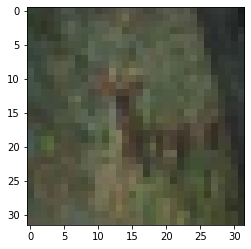

In [17]:
plt.imshow(x_train[10, :, :, :])

In [18]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
# Siempre se deben normalizar los datos
x_train /= 255
x_test /= 255

In [19]:
# Codificar a One Hot cada clase del conjunto de datos
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Arquitectura de la CNN

En este caso se va a aplicar la siguiente arquitectura:

- La **primera** capa es de convolución con 32 unidades, con relleno de $3 \times 3$, y función de activación ReLU.
- La **segunda** capa también es de convolución con 32 unidades, sin relleno, y función de activación ReLU.
- A estas dos capas le sigue una capa de _max pooling_ de $2 \times 2$.
- La **tercera** capa es de convolución con 64 unidades, con relleno de $3 \times 3$, y función de activación ReLU.
- La **cuarta** capa también es de convolución con 64 unidades, sin relleno, y función de activación ReLU.
- A estas dos capas le sigue una nueva capa de _max pooling_ de $2 \times 2$; aquí termina la etapa de características
- Con la etapa de clasificación se **aplanan** las imágenes y se ingresan a una red neuronal totalmente conectada de 512 unidades con función de activación ReLU.
- La **capa de salida** tiene tantas unidades como clases y función de activación softmax.

Entre cada capa se aplica _batch normalization_ y se quita el uso de sesgos para acelerar el entrenamiento.

In [20]:
# Todas las capas normalizadas, excpeto la última
arquitectura_norm = [
    # Capa de entrada, primera capa de características
    Conv2D(32, kernel_size=(3, 3),
           padding="same",
           input_shape=x_train.shape[1:],
           use_bias=False),
    BatchNormalization(scale=False),
    Activation("relu"),
    Conv2D(32, (3, 3), use_bias=False),
    BatchNormalization(scale=False),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Segunda capa de características
    Conv2D(64, kernel_size=(3, 3),
           padding="same",
           use_bias=False),
    BatchNormalization(scale=False),
    Activation("relu"),
    Conv2D(64, (3, 3), use_bias=False),
    BatchNormalization(scale=False),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Capa totalmente conectada
    Flatten(),
    Dense(512, use_bias=False),
    BatchNormalization(scale=False),
    Activation("relu"),
    # Capa de salida
    Dense(num_classes, activation="softmax")
]

In [21]:
# Se construye el modelo con esta arquitectura
model_normalizado = Sequential(arquitectura_norm)

## Optimizador y entrenamiento

Para el optimizador se emplea _Nadam_ con los [valores default](https://keras.io/optimizers/) de `keras`.

In [22]:
model_normalizado.compile(loss="categorical_crossentropy",
                          optimizer=Nadam(),
                          metrics=["accuracy"])

## Llamadas al modelo

Ahora se va a implementar _Early stopping_ como una llamada al modelo. Afortunadamente `keras` ya cuenta con una implementación de esta metodología. En este caso se monitereará la **pérdida del conjunto de validación**, y se estará observando su cambio a lo largo de 5 épocas.

Adicionalmente se va a implementar el guardado del mejor modelo cada que se evalua. A este se le conoce como _Model checkpoint_ en `keras`, lo que permite guardar el modelo que tenga el mejor valor monitoreado. En este caso se va a monitorear la **precisión en el conjunto de validación** y solamente se guardará el mejor modelo encontrado.

In [23]:
# Aplicar Early Stopping
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
# Guardar siempre el mejor modelo encontrado en base a la precisión de validación
mc = ModelCheckpoint("mejor_modelo.h5", monitor="val_acc", mode="max", verbose=1, save_best_only=True)

In [24]:
# Se procede a entrenar el modelo
historia = model_normalizado.fit(x_train, y_train,
                                 validation_split=0.2,
                                 epochs=epocas,
                                 verbose=1,
                                 callbacks=[es, mc])

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 126s 3ms/step - loss: 1.1688 - acc: 0.5898 - val_loss: 1.1700 - val_acc: 0.6021

Epoch 00001: val_acc improved from -inf to 0.60210, saving model to mejor_modelo.h5
Epoch 2/100
40000/40000 [==============================] - 120s 3ms/step - loss: 0.7645 - acc: 0.7328 - val_loss: 1.0196 - val_acc: 0.6518

Epoch 00002: val_acc improved from 0.60210 to 0.65180, saving model to mejor_modelo.h5
Epoch 3/100
40000/40000 [==============================] - 124s 3ms/step - loss: 0.5962 - acc: 0.7924 - val_loss: 0.7436 - val_acc: 0.7483

Epoch 00003: val_acc improved from 0.65180 to 0.74830, saving model to mejor_modelo.h5
Epoch 4/100
40000/40000 [==============================] - 125s 3ms/step - loss: 0.4569 - acc: 0.8398 - val_loss: 0.8535 - val_acc: 0.7280

Epoch 00004: val_acc did not improve from 0.74830
Epoch 5/100
40000/40000 [==============================] - 126s 3ms/step - loss: 0

Como se puede ver, el modelo dejó de entrenar abruptamente. Esto se debe a que el valor de pérdida de la última época de entrenamiento empezó a aumentar. Vamos a analizar esto con más detalle.

En la época 7 el **valor de la pérdida en el conjunto de validación** fue de 0.9331, mientras que en el época 8 fue de 09541. Al ver que este valor aumentó se activa el _Early stopping_ deteniendo por completo el entrenamiento.

Se debe notar que el monitoreo es cada 5 épocas. Con este se puede ver el siguiente gráfica para analizar visualmente el entrenamiento.

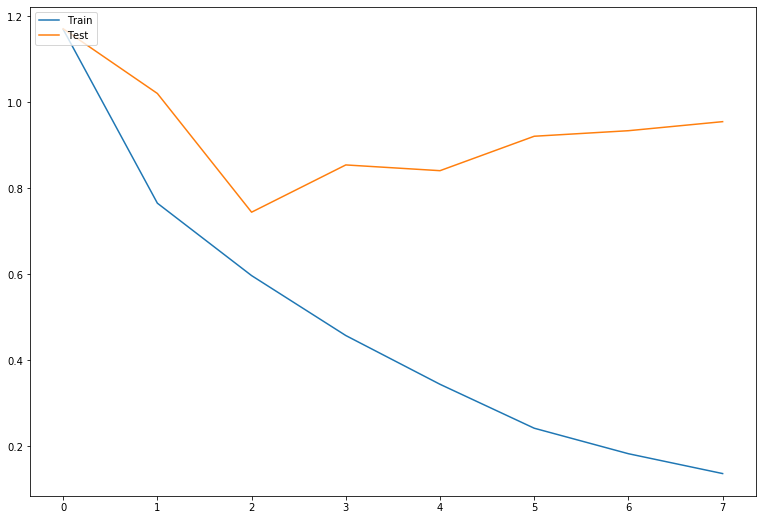

In [26]:
# Graficar los valores de pérdida en el entrenamiento
plt.figure(figsize=(13, 9))
plt.plot(historia.history['loss'])
plt.plot(historia.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Claramente se presenta sobreajuste, pero más importante que eso, el valor de la pérdida el conjunto de entrenamiento y el conjunto de validación están muy dispersos.

Este es el propósito de _Early stopping._ Cuando no existe una mejora sustancial en la clasificación del conjunto de validación es mejor detener el entrenamiento y afinar los hiperparámetros necesarios para mejorar el rendimiento del modelo.

In [28]:
# Cargar el mejor modelo encontrado
mejor_modelo = load_model("mejor_modelo.h5")

Con esto se carga el mejor modelo encontrado en el proceso de entrenamiento, que fue guardado mientras se evaluaba cada época. La ventaja de _Early stopping_ es que siempre se puede tener un modelo guardado y emplearlo para tener el conjunto de datos de prueba al respecto.

En el siguiente pedazo de código se hace justamente esto. Se cargó el modelo guardado y ahora se evalúa con un conjunto de datos que nunca fue visto por el modelo.

In [30]:
resultado = mejor_modelo.evaluate(x_test, y_test)
print(f"Pérdida: {resultado[0]}\nPrecisión: {resultado[1]}")

10000/10000 [==============================] - 10s 960us/step
Pérdida: 0.9576307853221894
Precisión: 0.7606


Como se puede ver, la pérdida y la precisión no son tan malos. Claramente no es un resultado _estado del arte_ pero al emplear _Early stopping_ el entrenamiento y cálculos innecesarios fueron evitados para obtener el mejor modelo posible.

## Ejercicios

1. Probar con diferentes valores para `patience` en el _Early stopping_. ¿Qué sucede si se aumentan? ¿Qué pasa cuando disminuyen?